In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nengo
import nengolib
import numpy as np

Let's see if we can get Aaron's delay network to recognize two different patterns that are multidimensional.  We want patterns where you need information from both dimensions, so let's do phase-shifted sign waves.

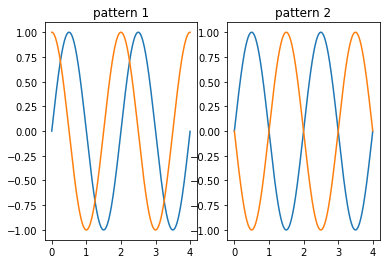

In [2]:
s_pattern = 4000                # number of data points in the pattern
t = np.arange(s_pattern)*0.001  # time points for the elements in the pattern

D = 2

pattern1 = np.vstack([np.sin(t*np.pi), np.cos(t*np.pi)]).T
pattern2 = np.vstack([np.sin(t*np.pi), -np.sin(t*np.pi)]).T



plt.subplot(1, 2, 1)
plt.plot(t, pattern1)
plt.title('pattern 1')
plt.subplot(1, 2, 2)
plt.plot(t, pattern2)
plt.title('pattern 2')
plt.show()

Now let's create a network that represents a rolling window in time (Aaron's "delay network").  The `process` determines what sort of pattern the network will be optimized for -- here we just go with white noise of a maximum of 3Hz.  `theta` determines how big the rolling window is -- here we use 0.5 seconds.

In [3]:
net = nengo.Network()
with net:
    process = nengo.processes.WhiteSignal(period=100., high=3., y0=0)
    
    rw = []
    for i in range(D):
        rw.append(nengolib.networks.RollingWindow(theta=0.5, n_neurons=3000, process=process, neuron_type=nengo.LIFRate()))

c:\users\terry\py3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


Now we need to create the training data for decoding out of the rolling window.  Our patterns are larger than the rolling window, so to create our training data we will take our patterns, shift them, and cut them down to the right size.  In order to then give that to nengo, we also need to project from the window's space to the internal representation space (using the `inv_basis`).

The `target` array is the desired output value for each of the slices of the pattern in `eval_points`.  We'll use 1 for pattern1 and -1 for pattern2.

In [4]:
s_window = 500

t_window = np.linspace(0, 1, s_window)
inv_basis = rw[0].inverse_basis(t_window)
    
eval_points = []
target = []
for i in range(s_pattern):
    eval_points.append(np.dot(inv_basis, np.roll(pattern1, i)[:s_window]).T)
    eval_points.append(np.dot(inv_basis, np.roll(pattern2, i)[:s_window]).T)
    target.append([1])
    target.append([-1])
eval_points = np.array(eval_points).reshape(len(eval_points), -1)

Now we can create a connection optimized to do this decoding

In [5]:
with net:
    
    pool = nengo.Ensemble(n_neurons=3000, dimensions=eval_points.shape[1],
                          neuron_type=nengo.LIFRate(), seed=1)
    start = 0
    for r in rw:
        nengo.Connection(r.state, pool[start:start+r.state.size_out])
        start += r.state.size_out
        
    result = nengo.Node(None, size_in=1)
    dec_conn = nengo.Connection(pool, result,
                     eval_points=eval_points, scale_eval_points=False,
                     function=target, synapse=0.1)

Let's try feeding in those two patterns and see what the response is

c:\users\terry\documents\github\nengolib\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

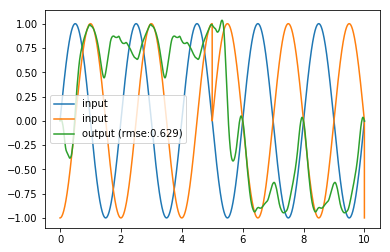

In [6]:
model = nengo.Network()
model.networks.append(net)
with model:
    offsets = [-np.pi/2, np.pi]
    def stim_func(t):
        offset = offsets[int(t/5) % len(offsets)]
        return np.sin(t*np.pi), np.sin(t*np.pi+offset)

    ideal_results = [1.0, -1.0]
    def ideal_func(t):
        return ideal_results[int(t/5) % len(ideal_results)]
    ideal_result = nengo.Node(ideal_func)
    
    
    
    stim = nengo.Node(stim_func)
    for i in range(D):
        nengo.Connection(stim[i], rw[i].input, synapse=None)
    
    p_result = nengo.Probe(result)
    p_stim = nengo.Probe(stim)
    p_pool = nengo.Probe(pool)
    p_ideal = nengo.Probe(ideal_result)
    
sim = nengo.Simulator(model)
sim.run(10)

plt.plot(sim.trange(), sim.data[p_stim], label='input')
plt.plot(sim.trange(), sim.data[p_result], label='output (rmse:%1.3f)' % np.sqrt(np.mean((sim.data[p_ideal]-sim.data[p_result])**2)))
plt.legend(loc='best')


Yay it works!  Still a pretty hight rmse, though.  Can we improve that?

One possible problem is that the data used for the output connection is assuming that the delay network does a perfect job.  What if we instead train it based on the real data coming out of the delay network?  This is basically just making our eval_points a bit more realistic.

c:\users\terry\documents\github\nengolib\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

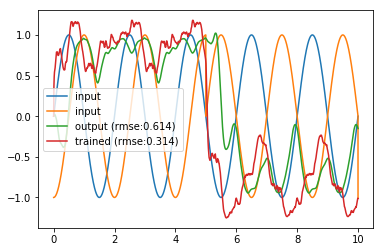

In [7]:
model = nengo.Network()
model.networks.append(net)
with model:
    offsets = [-np.pi/2, np.pi]
    def stim_func(t):
        offset = offsets[int(t/5) % len(offsets)]
        return np.sin(t*np.pi), np.sin(t*np.pi+offset)
    
    stim = nengo.Node(stim_func)
    for i in range(D):
        nengo.Connection(stim[i], rw[i].input, synapse=None)
        
    result2 = nengo.Node(None, size_in=1)
    nengo.Connection(pool, result2, eval_points=sim.data[p_pool], function=sim.data[p_ideal], scale_eval_points=False)
    
    p_result = nengo.Probe(result)
    p_result2 = nengo.Probe(result2)
    p_stim = nengo.Probe(stim)
    
sim2 = nengo.Simulator(model)
sim2.run(10)

plt.plot(sim2.trange(), sim2.data[p_stim], label='input')
plt.plot(sim2.trange(), sim2.data[p_result], label='output (rmse:%1.3f)' % np.sqrt(np.mean((sim.data[p_ideal]-sim2.data[p_result])**2)))
plt.plot(sim2.trange(), sim2.data[p_result2], label='trained (rmse:%1.3f)' % np.sqrt(np.mean((sim.data[p_ideal]-sim2.data[p_result2])**2)))
plt.legend(loc='best')

That's some improvement!  What else can we do?

The `pool` Ensemble is pretty high-dimensional, and for some high-dimensional functions, it's useful to get a better encoder distribution.  So, let's use feedback alignment to find better encoders:

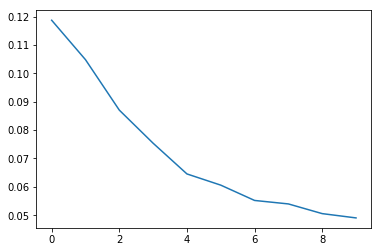

In [8]:
model = nengo.Network()
model.networks.append(net)
with model:
    result2 = nengo.Node(None, size_in=1)
    conn = nengo.Connection(pool, result2, eval_points=sim.data[p_pool], function=sim.data[p_ideal], scale_eval_points=False)
    
import nengo_encoder_learning
error = nengo_encoder_learning.improve(conn, learning_rate=1e-2, steps=10)

plt.plot(error)

That looks like it should improve things!  How well does it do?

c:\users\terry\documents\github\nengolib\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

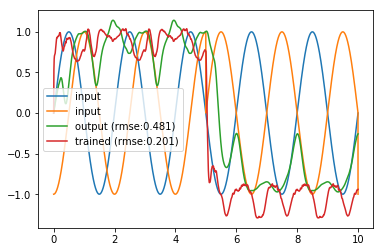

In [9]:
model = nengo.Network()
model.networks.append(net)
with model:
    offsets = [-np.pi/2, np.pi]
    def stim_func(t):
        offset = offsets[int(t/5) % len(offsets)]
        return np.sin(t*np.pi), np.sin(t*np.pi+offset)
    
    stim = nengo.Node(stim_func)
    for i in range(D):
        nengo.Connection(stim[i], rw[i].input, synapse=None)
        
    result2 = nengo.Node(None, size_in=1)
    nengo.Connection(pool, result2, eval_points=sim.data[p_pool], function=sim.data[p_ideal], scale_eval_points=False)
    
    p_result = nengo.Probe(result)
    p_result2 = nengo.Probe(result2)
    p_stim = nengo.Probe(stim)
    
sim2 = nengo.Simulator(model)
sim2.run(10)

plt.plot(sim2.trange(), sim2.data[p_stim], label='input')
plt.plot(sim2.trange(), sim2.data[p_result], label='output (rmse:%1.3f)' % np.sqrt(np.mean((sim.data[p_ideal]-sim2.data[p_result])**2)))
plt.plot(sim2.trange(), sim2.data[p_result2], label='trained (rmse:%1.3f)' % np.sqrt(np.mean((sim.data[p_ideal]-sim2.data[p_result2])**2)))
plt.legend(loc='best')